# HSCIC Prescription data exploration with Google BigQuery and Python

I was excited to see https://openprescribing.net making it possible for people to get a good look at the prescription data that is available through the HSCIC website. Although the data has been technically available for some time it has, until https://openprescribing.net, been very difficult to use it as it requires expert data wrangling skills to download, manipulate and analyse.

A while back I'd seen some analysis of the rosuvastatin inefficiency based on the HSCIC data (presented here https://www.youtube.com/watch?list=PL055Epbe6d5YtvCnEVzbkbRCoMFOLj202&v=VKAdGEEgC5o). Openprescribing.net includes rosuvastatin prescription patterns as a sort of CCG best practice indicator at https://openprescribing.net/ccg/. At the time I wondered what sort of methods or technology could be used to automatically discover similar or other inefficiences or abnormal practice and came up with one potential approach. I worked on it a little bit but didn't invest enough time to produce any useful results. Inspired by the news of openprescribing.net I thought I'd describe it in case it was of any interest. For example, it might help:

- speed up any offline exploration before making results available on the openprescribing website
- discover further health check metrics like the rosuvastatin measure 
- discover correlations between good/bad prescription patterns
- cluster CCGs or GP practices into similarity groups to provide a sort of framework for further studying prescription practice

It's really useful to be able to browse through the data by CCG or chemical but it would also be helpful to be able to discover the interesting chemicals and stories without exhaustive, exhausting browsing. My working assumption is that some such discovery methods will factorise into two parts:

- straightforward aggregations across the hundreds of millions of rows of raw data yielding a much smaller set of results (say tens/hundreds of thousands)
- more sophisticated analysis of these aggregate results

Hence, it is important to get the big data into some technology that can execute useful aggregations and basic analyses at low latency - so that exploration can proceed. Google BigQuery provides blazingly fast analysis on large datasets through a SQL interface, so seems a good fit to me. I've used BigQuery at work for this type of activity and know it performs well: typically queries on datasets of this size return in less than 10 seconds. Furthermore it is also more-or-less free to use.

The approach I've been prototyping is to:

- load the prescription data into BigQuery and use its SQL interface to get aggregate statistics
- analyse the much smaller aggregate results in python (which has good library and notebook support for data analysis)

In this notebook, in the spirit of a proof of concept, I demonstrate how this approach might work and run a few really simple analyses to discover some interesting patterns.


# Upload process in more detail

Before getting to the examples here's some more detail the steps I took to wrangle the data into BigQuery:

- Downloaded to my machine the following files from http://datagov.ic.nhs.uk/presentation/ (each took around 2mins to get)
  - 2013_04_April/T201304PDPI+BNFT.csv
  - 2013_05_May/T201305PDPI+BNFT.CSV
  - ...
  - 2015_09_September/T201509PDPI+BNFT.CSV
- Ignored the files before April 2013 for this experiment (I read on the HSCIC site that the interpretation of one of the columns changed at this point so wanted to avoid any complications arising from that at this stage)
- Executed a simple transformation to add additional columns (BNF_CHAPTER, BNF_SECTION, BNF_PARAGRAPH etc.) - just substrings of the BNF_CODE. I wanted to be able to group by chapter, section, paragraph etc inside BigQuery so needed these extra columns
- Created a project and dataset in Google BigQuery
- Defined the schema for a BigQuery table to contain the prescription data (given below)
- Loaded the prescription CSVs into a BigQuery table using the command line tool bq supplied by Google (each took around 6mins to insert)
- The resulting Google BigQuery table has:
  - Table Size: 47.4 GB
  - Number of Rows: 302,894,233
- Ran a few spot checks by comparing aggregations inside BigQuery with those available on https://openprescribing.net and found the two sources agreed (but I have not done any systematic testing)


### Schema

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>name</th>
      <th>type</th>
      <th>mode</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SHA</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>1</th>
      <td>PCT</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>2</th>
      <td>PRACTICE</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>3</th>
      <td>BNF_CHAPTER</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>4</th>
      <td>BNF_SECTION</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>5</th>
      <td>BNF_PARAGRAPH</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>6</th>
      <td>BNF_SUBPARAGRAPH</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>7</th>
      <td>BNF_CHEMICAL</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>8</th>
      <td>BNF_PRODUCT</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>9</th>
      <td>BNF_CODE</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>10</th>
      <td>BNF_NAME</td>
      <td>string</td>
      <td>required</td>
    </tr>
    <tr>
      <th>11</th>
      <td>ITEMS</td>
      <td>integer</td>
      <td>required</td>
    </tr>
    <tr>
      <th>12</th>
      <td>NIC</td>
      <td>float</td>
      <td>required</td>
    </tr>
    <tr>
      <th>13</th>
      <td>ACT_COST</td>
      <td>float</td>
      <td>required</td>
    </tr>
    <tr>
      <th>14</th>
      <td>QUANTITY</td>
      <td>integer</td>
      <td>required</td>
    </tr>
    <tr>
      <th>15</th>
      <td>PERIOD</td>
      <td>string</td>
      <td>required</td>
    </tr>
  </tbody>
</table>

# Simple queries

OK, the data is in BigQuery so let's run some simple queries. BigQuery executes SQL against the data so all we need to do is send it some SQL and collect the results.

I've written a function to do this. It returns the results in a pandas dataframe, a standard abstraction for working with tabular data in python.

I also need a function to lookup BNF chapter, section, paragraph etc from a BNF_CODE. So let's import all the library support we need here:

In [3]:
# set up this notebook to be able to plot charts inline and import libraries
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


## Overall scope of the data: rows, CCGs, practices, etc. per period

Let's count rows per period plus some other stats, to get a feel for the scope of the data.

This query takes only a couple of seconds to execute. It produces a python dataframe (http://pandas.pydata.org/), which then gets displayed as a table automatically inside this IPython notebook.

In [2]:
gbq.query(
    '''
    select PERIOD,count(1) N_ROWS,
           count(distinct PCT) N_PCTS,count(distinct PRACTICE) N_PRACTICES,
           count(distinct BNF_CHAPTER) N_BNF_CHAPTERS,count(distinct BNF_SECTION) N_BNF_SECTIONS,
           count(distinct BNF_PARAGRAPH) N_BNF_PARAGRAPHS,count(distinct BNF_CODE) N_BNF_CODES,
    from [nhs.PDPI2]
    group by PERIOD order by PERIOD
    ''',
    max_rows=1000,
    index=['PERIOD']
)

Waiting on bqjob_re67fecf2135a0a4_00000151e8b4f8fb_1 ... (0s) Current status: DONE   


,N_BNF_CHAPTERS,N_BNF_CODES,N_BNF_PARAGRAPHS,N_BNF_SECTIONS,N_PCTS,N_PRACTICES,N_ROWS
PERIOD,,,,,,,
201304,21,20310,697,201,358,9753,10024498
201305,21,20533,699,202,359,9808,10087516
201306,21,20497,693,199,374,9820,9917174
201307,21,20990,706,203,383,10014,10244381
201308,21,20482,705,201,375,10011,9984133
201309,21,20533,702,202,378,10069,9984725
201310,21,21011,711,202,360,10014,10165642
201311,21,20457,705,199,360,10066,10053266
201312,21,20537,698,201,349,9987,10073812


## Most costly BNF "paragraphs"

Here we're just aggregating over the entire dataset, to rank the BNF paragraphs by total cost. I also display the total item count on the chart.

### BigQuery

Just SQL.

In [354]:
df=gbq.query(
    '''
    select BNF_PARAGRAPH,sum(ITEMS) TOTAL_ITEMS, sum(ACT_COST) TOTAL_ACT_COST
    from [nhs.PDPI2]
    group by BNF_PARAGRAPH order by TOTAL_ACT_COST desc
    ''',
    max_rows=20,
    cast={'TOTAL_ITEMS':int,'TOTAL_ACT_COST':float}
)

Waiting on bqjob_r7c6b869977ceb5d2_00000151ee703b12_1 ... (0s) Current status: DONE   
20 rows in 3.63 seconds


### Post processing

Very little here: just map the paragraph coordinates to the descriptive titles and set as the index on the dataframe returned above. Then sort by total cost and call the dataframe's plot method (which delegates to matplotlib, http://matplotlib.org/).

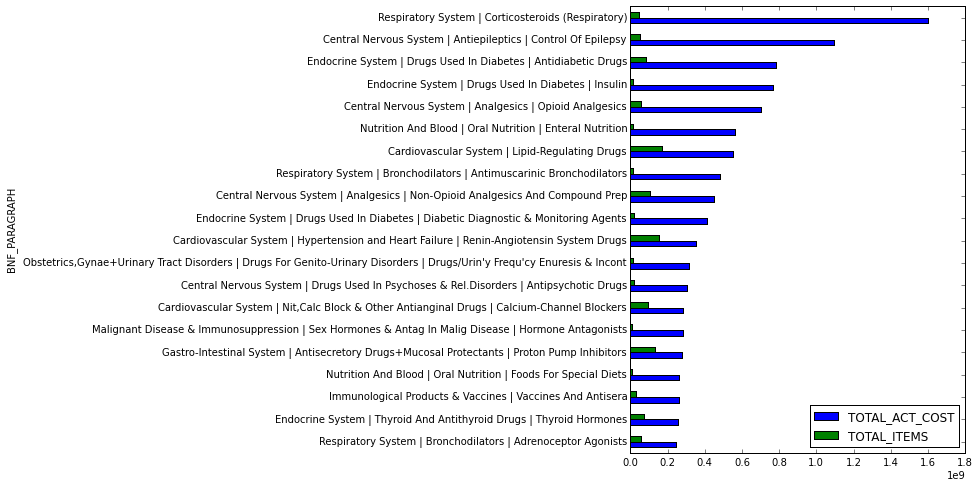

In [358]:
df.index=df['BNF_PARAGRAPH'].apply(bnf.description)
df.sort(columns=['TOTAL_ACT_COST']).plot(kind='barh',figsize=(6,8))

## Rosuvastatin : Atorvastatin item ratio

For variety, instead of producing a time plot for each CCG or a month-focused bar graph for all CCGs, as on openprescribing.net, let's make a boxplot for the set of ratios each CCG displays over the whole period in the database. The openprescribing approach is great, this really is just for variety and illustration of the BigQuery + python exploration approach.

### BigQuery

In [400]:
df=gbq.query(
    '''
    select PERIOD,PCT,BNF_CHEMICAL,sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    where BNF_CHEMICAL in ("0212000AA","0212000B0")
    group by PERIOD,PCT,BNF_CHEMICAL order by TOTAL_ITEMS desc
    ''',
    max_rows=30000,
    cast={'N_ROWS':int,'TOTAL_ITEMS':float},
    index=['PERIOD','PCT','BNF_CHEMICAL'] # this is the pandas dataframe index, not an index in BigQuery
)

Waiting on bqjob_r355f45ad36d05cd8_00000151eeae5a1e_1 ... (0s) Current status: DONE   
13895 rows in 5.84 seconds


### Post processing

We need to perfom a little manipulation in python to produce a readable box plot (showing the variation in the ratio for each CCG over the total time period in the database).

- Discard CCGs whose minumum mean number of ITEMS is lower than a threshold (to avoid noise)
- Compute the R:A ration
- Decode the CCG code to its descriptive name
- Order the CCGs by the 25th percentile (over time) of their ratios and keep only the top 50
- Defer to mathplotlib for the boxplot

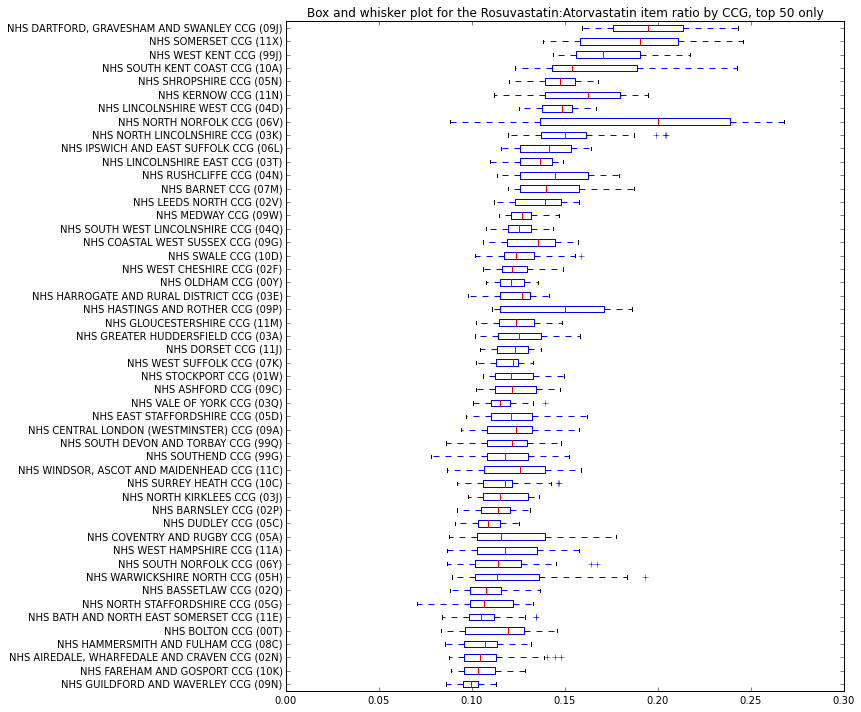

In [403]:
means=df.groupby(level=1).mean()
frequent=set(means[means['TOTAL_ITEMS']>50].index)
df2=df[df.index.map(lambda x:x[1] in frequent)].unstack()['TOTAL_ITEMS']
df2['ratio']=df2['0212000AA']/df2['0212000B0']
df2.index= pd.MultiIndex.from_tuples(df2.index.map(lambda x: (x[0],"%s (%s)" % (ccg.name(x[1]),x[1]))))

def percentile(p): # return a function that returns the pth percentile
    def g(x): # return pth percentile
        return sorted(x)[int(p/100.*len(x))]
    return g
topCCGs=df2[['ratio']].groupby(level=1).agg(percentile(25)).sort(columns=['ratio']).index[-50:]
ax=df2['ratio'].unstack()[topCCGs].plot(kind='box',vert=False,figsize=(10,12),xlim=0,
                                     title='Box and whisker plot for the Rosuvastatin:Atorvastatin item ratio by CCG, top 50 only')

### Observations and cross check

09J, 11X and 99J (amongst others) look like outliers. This cross checks with

- 09J: https://openprescribing.net/analyse/#org=CCG&orgIds=09J&numIds=0212000AA&denomIds=0212000B0
- 11X: https://openprescribing.net/analyse/#org=CCG&orgIds=11X&numIds=0212000AA&denomIds=0212000B0
- 99J: https://openprescribing.net/analyse/#org=CCG&orgIds=99J&numIds=0212000AA&denomIds=0212000B0

# BNF paragraphs whose cost varies most over time

Which types of prescription vary most in cost over time? We'll look at this at the level of BNF paragraph. 

### Big Query

First we group the data by BNF paragraph and time in BigQuery.

In [4]:
df=gbq.query(
    '''
    select PERIOD,BNF_PARAGRAPH,sum(ACT_COST) TOTAL_ACT_COST,sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    group by PERIOD,BNF_PARAGRAPH
    ''',
    max_rows=30000,index=['BNF_PARAGRAPH','PERIOD'],cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float}
)

Waiting on bqjob_r77aa2af923477d32_00000151ef8c6bcc_1 ... (0s) Current status: DONE   
21239 rows in 5.79 seconds


### Post processing

Once we have the aggregate results from BigQuery, we can rank the paragraphs by temporal variation, then take the top N and plot a timeseries for each.

For the neasure of temporal variation I've chosen variance/mean of cost per month as this seemed to pull out some interesting timeseries, but there are other measures we could try.

There are some clear examples of seasonal variation, for flu and hayfever, I believe. There are also a number of cases of increase in cost despite constant levels of prescription. Could some of these be due to price hikes?

The next cell contains the top 20 paragraphs, the most variable first.

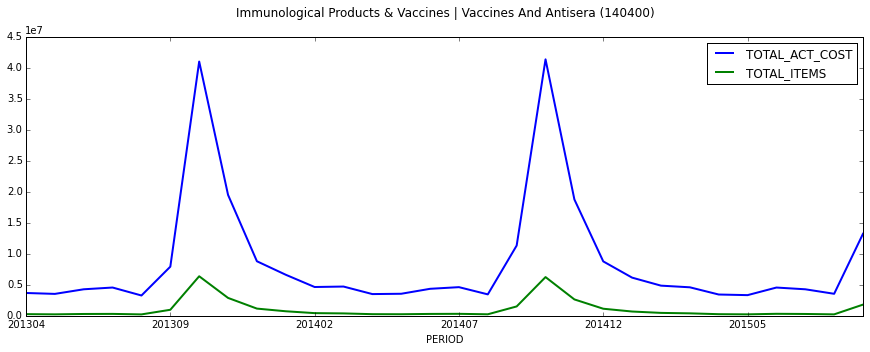

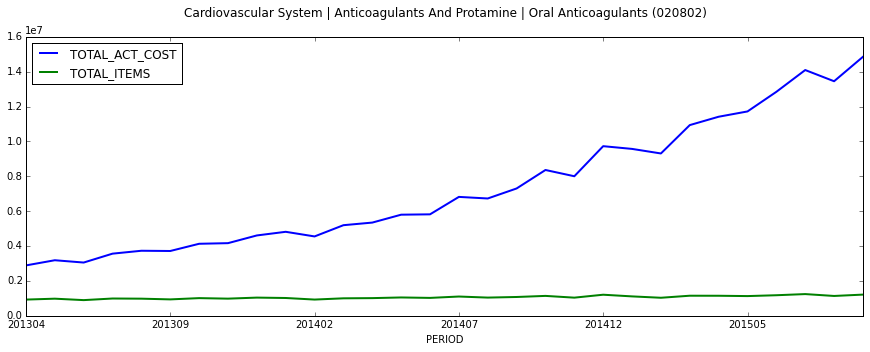

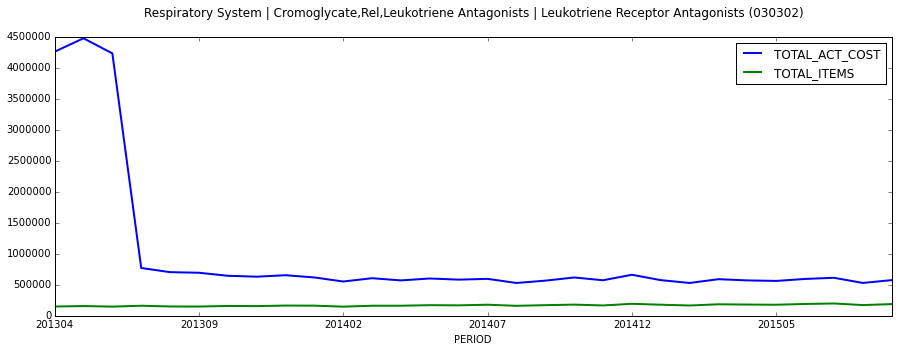

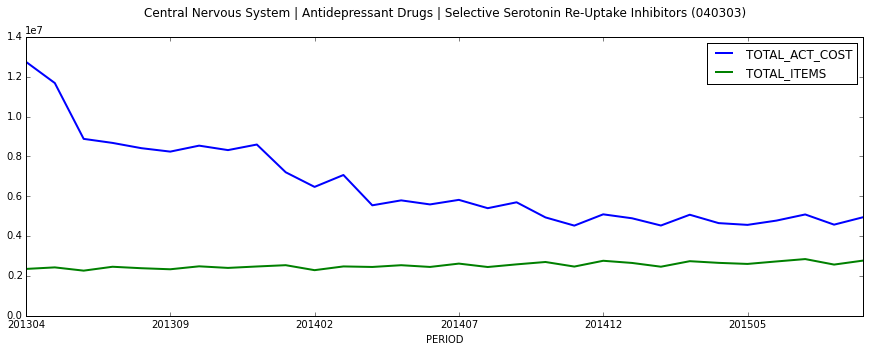

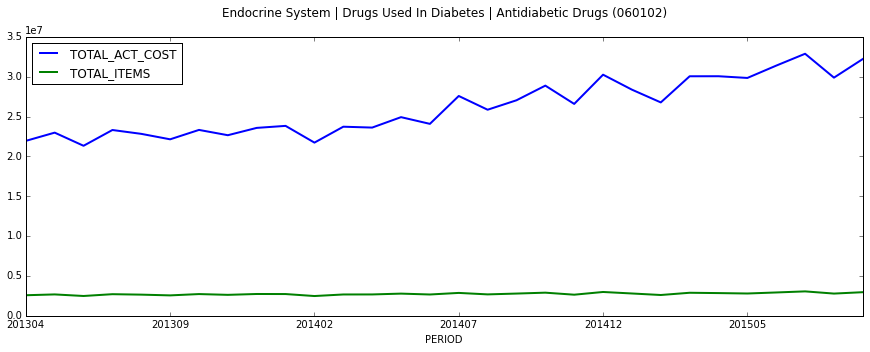

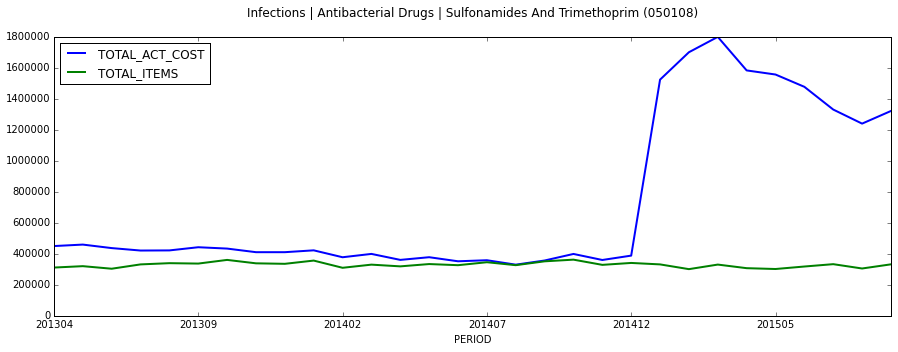

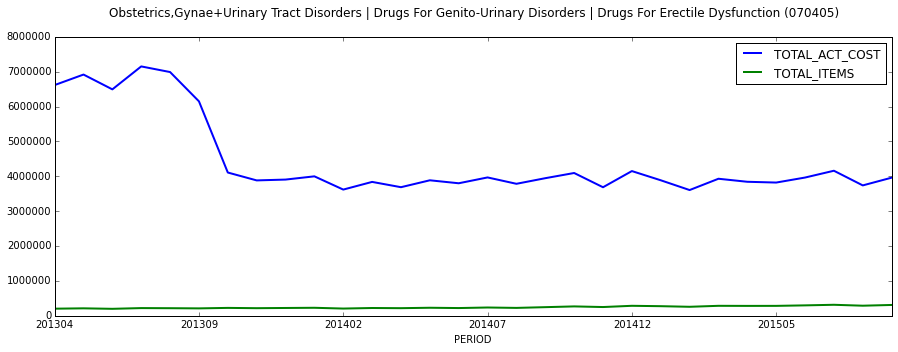

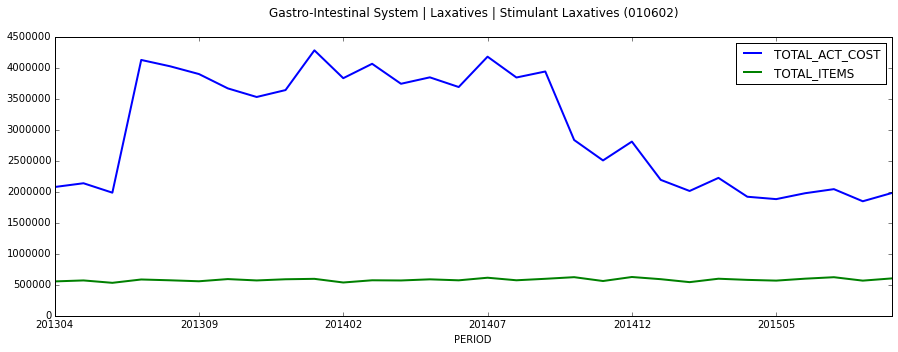

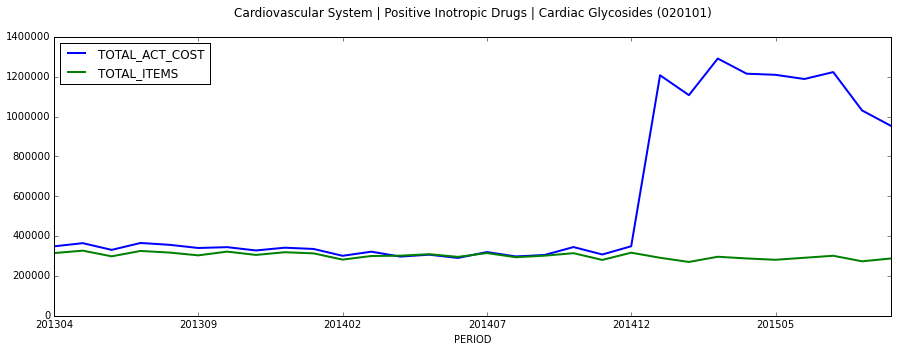

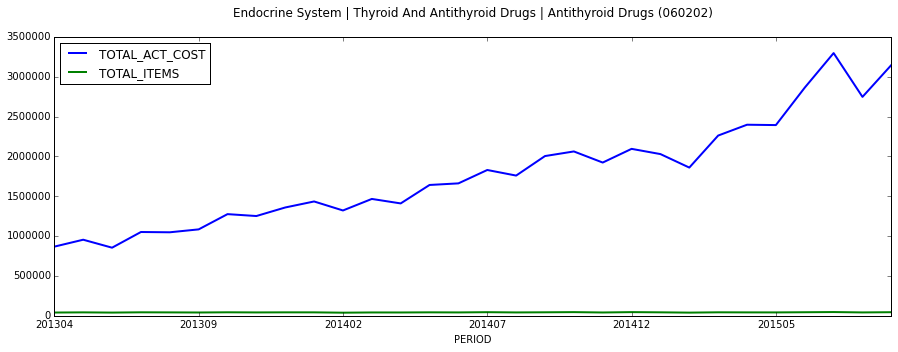

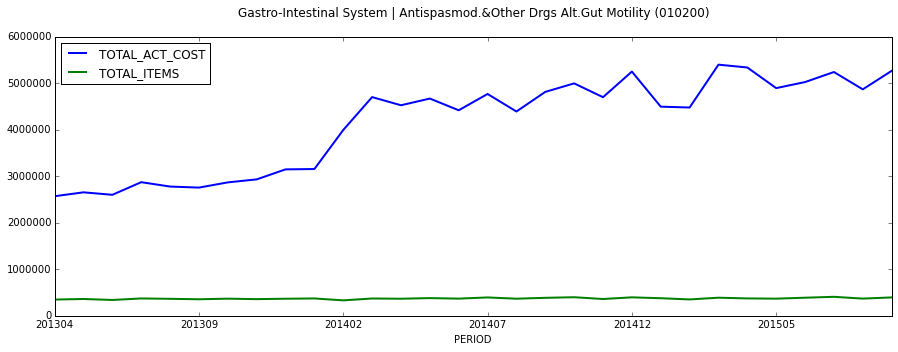

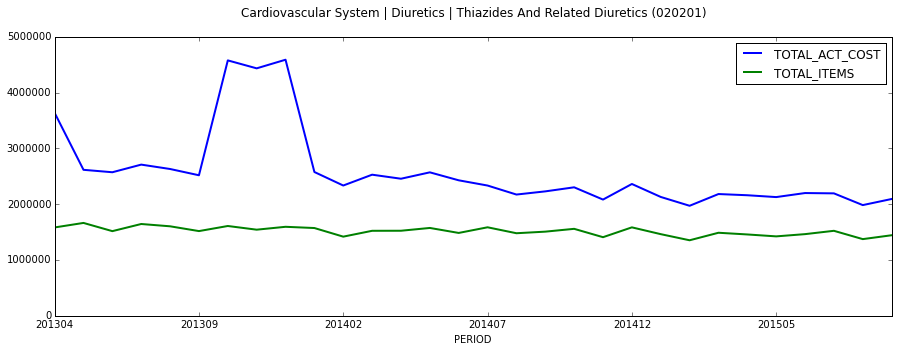

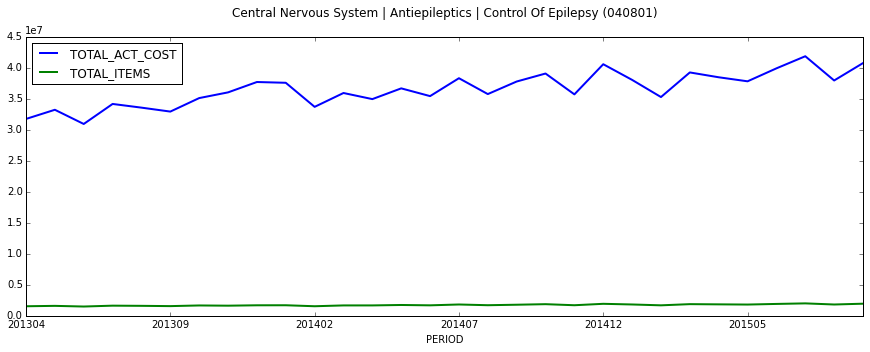

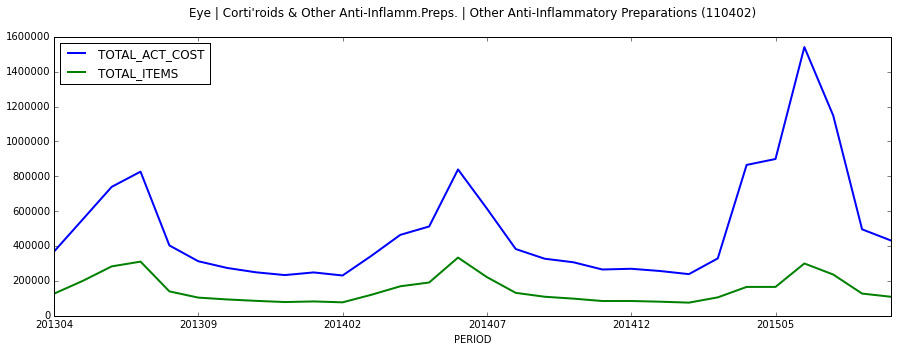

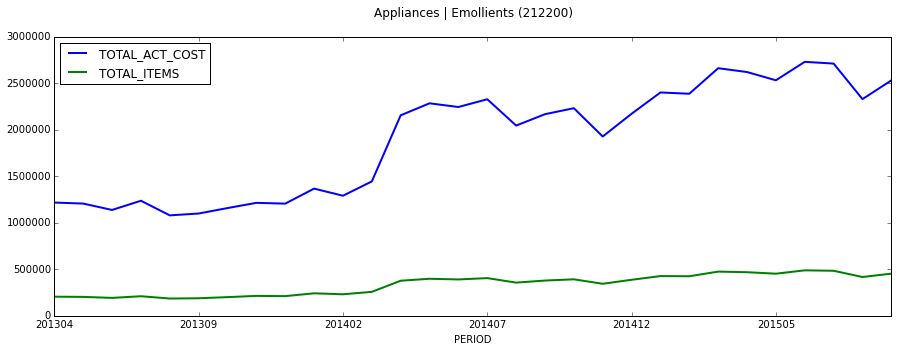

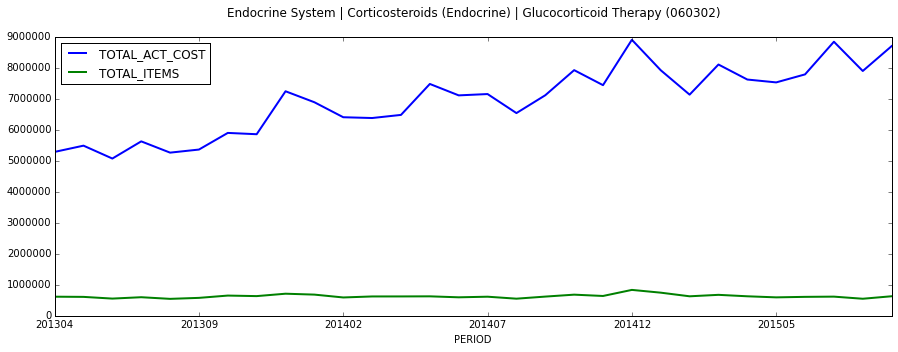

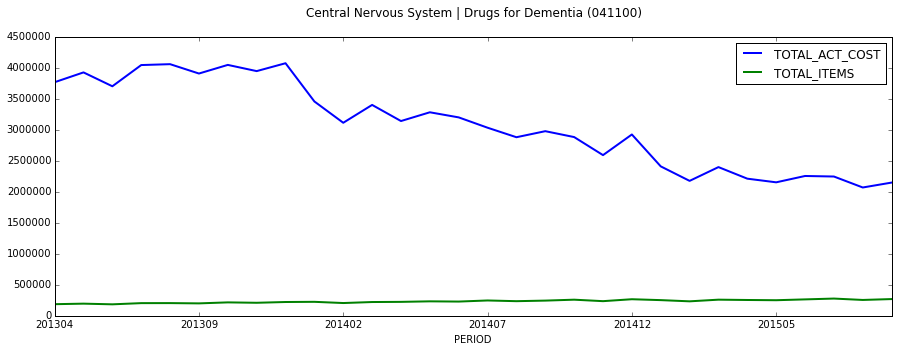

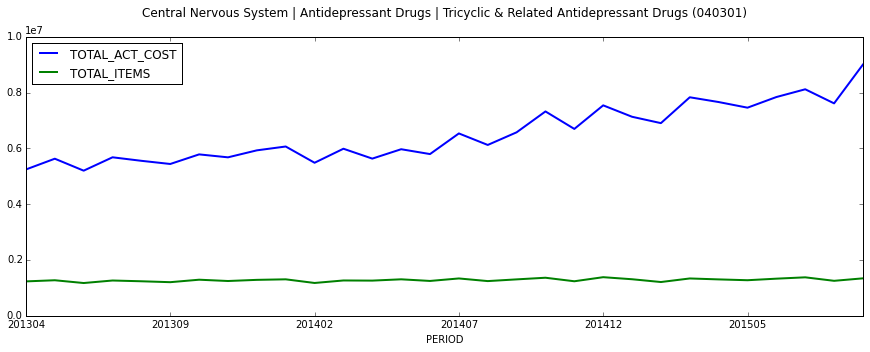

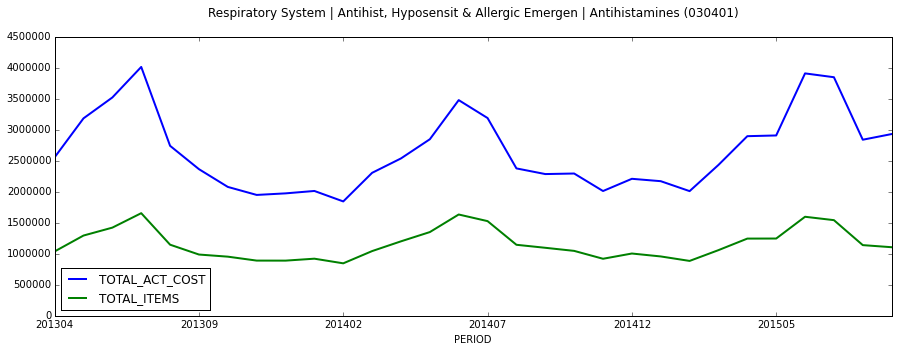

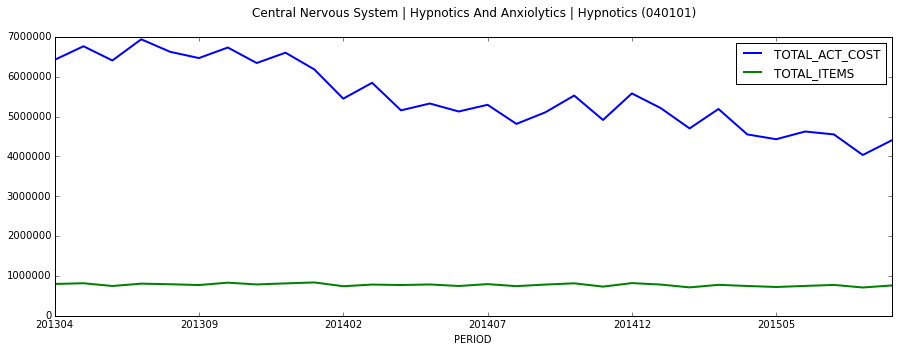

In [5]:
def score(x):
    return np.var(x)/np.mean(x)
scores=df.groupby(level=0).agg(score).sort(columns=['TOTAL_ACT_COST'],ascending=False)
for highscorer in scores[:20].index:
    df.ix[highscorer].sort().plot(ylim=0,figsize=(15,5),linewidth=2,
                                  title="%s (%s)\n" % (bnf.description(highscorer),highscorer))

### Observations and cross check

The timeseries for 050108 shows a striking jump in cost, without an associated increase in number of items. I've plotted it again below, and re-queried to find the breakdown of associated products.

The results agree with those on openprescribing: https://openprescribing.net/chemical/0501080W0

A similar analysis could be done based on variability in total items prescribed.

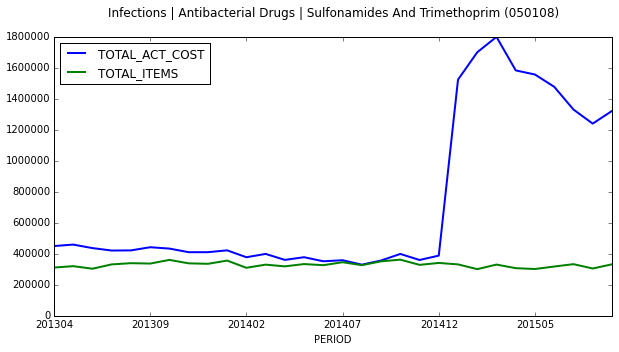

In [35]:
highscorer='050108'
df.ix[highscorer].sort().plot(ylim=0,figsize=(10,5),linewidth=2,
                              title="%s (%s)\n" % (bnf.description(highscorer),highscorer))

In [31]:
gbq.query(
    '''
    select BNF_CODE,BNF_NAME,sum(ACT_COST) TOTAL_ACT_COST,sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    where BNF_PARAGRAPH="050108"
    group by BNF_CODE,BNF_NAME order by TOTAL_ACT_COST desc
    ''',
    max_rows=10,cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float}
)

Waiting on bqjob_r2437ef6233108040_00000151e86d0288_1 ... (3s) Current status: DONE   


,BNF_CODE,BNF_NAME,TOTAL_ACT_COST,TOTAL_ITEMS
0,0501080W0AAAEAE,Trimethoprim_Tab 200mg,14275490.77,7538611
1,0501080W0AAADAD,Trimethoprim_Tab 100mg,3508754.38,1220777
2,0501080W0AAAIAI,Trimethoprim_Oral Susp 50mg/5ml S/F,1967571.16,821775
3,0501080D0AAAHAH,Co-Trimoxazole_Tab 80mg/400mg,993228.47,190454
4,0501080D0AAAJAJ,Co-Trimoxazole_Tab 160mg/800mg,320295.32,51641
5,0501080T0AAAAAA,Sulfamethoxypyridazine_Tab 500mg,249413.70,225
6,0501080J0AAABAB,Sulfadiazine_Tab 500mg,171118.07,1289
7,0501080V0AAADAD,Sulfapyridine_Cap 250mg,149208.38,100
8,0501080D0AAACAC,Co-Trimoxazole_Susp Paed 240mg/5ml S/F,81479.64,18213
9,0501080D0AAAEAE,Co-Trimoxazole_Oral Susp 480mg/5ml,55033.18,6615


# BNF paragraphs whose (fractional) cost varies most over the CCGs

I thought it would be interesting to see which BNF paragraphs vary most in cost over the CCGs.

For this, I've focused on data from 2015.

Let's start by surveying the CCGs so we understand the terrain over which we're studying the variation of the prescribed products. We'll see that there are two distinct clusters and we'll use just one of them for this investigation.


## BigQuery the CCG level data

For each CCG, we retreive total expenditure as well as number of practices and BNF paragraphs prescribed.

In [6]:
ccgspend=gbq.query(
    '''
    select PCT, sum(ACT_COST) TOTAL_ACT_COST,
    count(distinct PRACTICE) N_PRACTICES,count(distinct BNF_PARAGRAPH) N_BNF_PARAGRAPHS
    from [nhs.PDPI2]
    where PERIOD contains "2015"
    group by PCT
    ''',
    max_rows=1000,index=['PCT'],cast={'TOTAL_ACT_COST':float,'N_PRACTICES':int,'N_BNF_PARAGRAPHS':int}
)

Waiting on bqjob_r4da6eedf9f7c594f_00000151ef8c9fd4_1 ... (0s) Current status: DONE   
378 rows in 2.07 seconds


## CCG Clustering
### Histograms

First let's see how CCGs bin by spend, paragraphs and practices, by plotting histograms (NB log scale on y-axis).

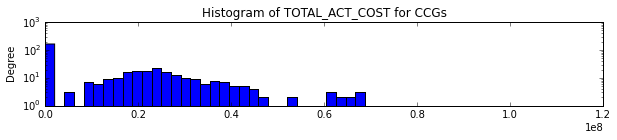

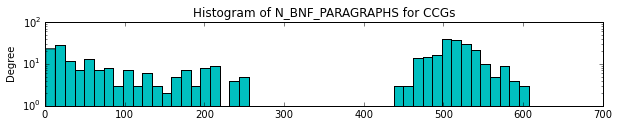

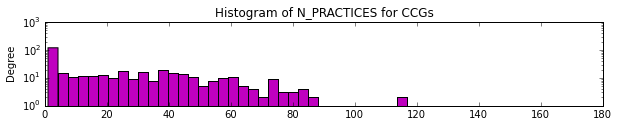

In [7]:
for i,x in enumerate(['TOTAL_ACT_COST','N_BNF_PARAGRAPHS','N_PRACTICES']):
    ccgspend[x].plot(kind='hist',bins=50,figsize=(10,1.5),logy=True,title='Histogram of %s for CCGs' % x,color='bcm'[i])
    show()

### Scatter plots

The cost and paragraph plots are clearly segmented. Let's look at pairwise correlations on scatter plots.

I'm colouring by whether or not N_BNF_PARAGRAPHS>400, which looks like a good separator.

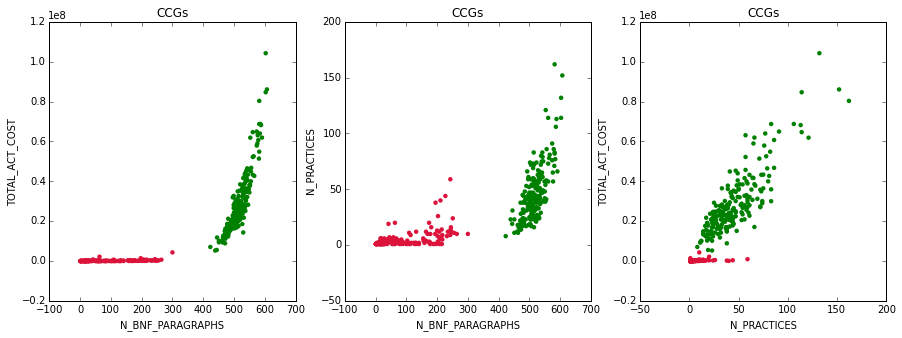

In [103]:
colours = np.where(ccgspend['N_BNF_PARAGRAPHS'] > 400,'green','crimson')
fig,axs=plt.subplots(1,3,figsize=(15,5))
ccgspend.plot(kind='scatter',x='N_BNF_PARAGRAPHS',y='TOTAL_ACT_COST',title='CCGs',ax=axs[0],c=colours,linewidth=0)
ccgspend.plot(kind='scatter',x='N_BNF_PARAGRAPHS',y='N_PRACTICES',title='CCGs',ax=axs[1],c=colours,linewidth=0)
ccgspend.plot(kind='scatter',x='N_PRACTICES',y='TOTAL_ACT_COST',title='CCGs',ax=axs[2],c=colours,linewidth=0)

### Keep only the green cluster of CCGs for the paragraph variation analysis

As we look at variation of cost of prescribed products over CCGs, restrict attention to only those CCGs that prescribe from more than 400 paragraphs (the green cluster in the plots above).

It's worth noting that none of the discarded CCGs in this 2015 result decoded by (what I'm assuming to be) the standard dictionary at https://data.gov.uk/dataset/england-nhs-connecting-for-health-organisation-data-service-data-files-of-nhsorganisations; numbers in next output cell:

In [9]:
ccgkeep=ccgspend[ccgspend['N_BNF_PARAGRAPHS']>400]
print "="*60
print "Number of kept CCGs decoded : not decoded = %i : %i" % (len(ccgkeep[ccgkeep.index.isin(ccg.ccgs())]),len(ccgkeep[~ccgkeep.index.isin(ccg.ccgs())]))

ccgdiscard=ccgspend[ccgspend['N_BNF_PARAGRAPHS']<=400]
ccgdiscard[ccgdiscard.index.isin(ccg.ccgs())]
print "Number of discarded CCGs decoded : not decoded = %i : %i" % (len(ccgdiscard[ccgdiscard.index.isin(ccg.ccgs())]),len(ccgdiscard[~ccgdiscard.index.isin(ccg.ccgs())]))

Number of kept CCGs decoded : not decoded = 212 : 0
Number of discarded CCGs decoded : not decoded = 0 : 166


## BigQuery for the BNF paragraph level data

Now let's query for the cross tabulation between NBF paragraph and CCG. We'll restrict the query to the selected CCGs. We've got 200 or so CCGs and around 700 BNF paragraphs, hence the high setting for max_rows.

In [10]:
ccgstring=','.join('"%s"' % x for x in ccgkeep.index)
para_ccg=gbq.query(
    '''
    select BNF_PARAGRAPH,PCT,sum(ACT_COST) TOTAL_ACT_COST,sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    where PCT in (%s) and PERIOD contains "2015"
    group by BNF_PARAGRAPH,PCT
    ''' % ccgstring,
    max_rows=150000,index=['BNF_PARAGRAPH','PCT'],cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float}
)

Waiting on bqjob_r6ed56020c13c8a27_00000151ef8d0e75_1 ... (0s) Current status: DONE   
109507 rows in 13.06 seconds


### Join the data and compute ratios

We're after fractional of cost of each paragraph for each CCG, so we need to divide by total spend per CCG. We can do this by joining our new data to the previous CCG dataset which included total CCG spend.

Here's the code and the first few rows of the resulting data frame.

In [11]:
para_ccg2=para_ccg.join(ccgspend[['TOTAL_ACT_COST']],rsuffix='_CCG')
para_ccg2['FRAC_ACT_COST']=para_ccg2['TOTAL_ACT_COST']/para_ccg2['TOTAL_ACT_COST_CCG']
para_ccg2.index= pd.MultiIndex.from_tuples(para_ccg2.index.map(lambda x: (x[0],ccg.name(x[1]))))
para_ccg2.index.set_names(['BNF_PARAGRAPH','CCG'],inplace=True)
para_ccg2.head()

,,TOTAL_ACT_COST,TOTAL_ITEMS,TOTAL_ACT_COST_CCG,FRAC_ACT_COST
BNF_PARAGRAPH,CCG,,,,
091102,NHS SOUTH EASTERN HAMPSHIRE CCG,2687.96,142,25162200.3,0.000107
110600,NHS SOUTH EASTERN HAMPSHIRE CCG,205219.97,21514,25162200.3,0.008156
120302,NHS SOUTH EASTERN HAMPSHIRE CCG,2062.41,535,25162200.3,0.000082
130201,NHS SOUTH EASTERN HAMPSHIRE CCG,293934.43,43647,25162200.3,0.011682
130601,NHS SOUTH EASTERN HAMPSHIRE CCG,48729.10,3977,25162200.3,0.001937


### Quick look at Lipid-Regulating Drugs

Now we have the fractional cost data, let's revisit the BNF paragraph Rosuvastatin and Atorvastatin belong to (021200) and plot how it's fractional cost varies across the CCGs. NB the denominator here is total spend by a CCG across all BNF codes.



To plot something readbable, instead of showing the fractional cost of this paragraph for each named CCGs, I pick out the top and bottom 5 fractions and also throw in the 25th, 50th and 75th percentiles and plot those in the righthand subplot. The percentiles are coloured green. I also provide the histogram on the left to give the bigger picture.

There are quite a few lines of code in the next cell to achieve this. There's no analysis going on, only -- tedious -- configuration of the plots.

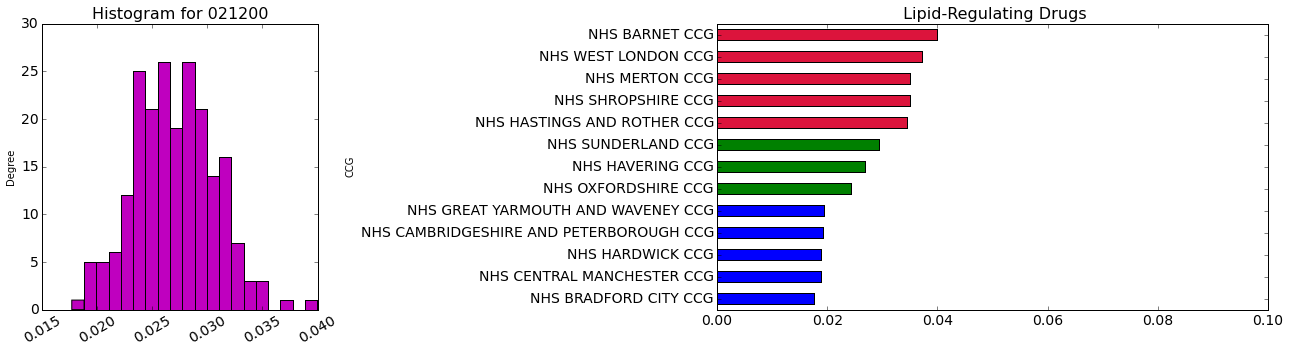

In [104]:
from matplotlib import gridspec
# beware: uses global para_ccg2!
def plot_folded(bnfcode,xlim=None):
    x=para_ccg2.ix[bnfcode][['FRAC_ACT_COST']]
    extrema=5
    colours=['b']*extrema+['g','g','g']+['crimson']*extrema
    r=range(extrema)+[int(0.25*len(x)),int(len(x)/2),int(0.75*len(x))]+range(-extrema,0)
    fig = plt.figure(figsize=(18,5))
    gs = gridspec.GridSpec(1,2,width_ratios=[1,2])
    axes=map(plt.subplot,gs)
    x.plot(kind='hist',bins=20,ax=axes[0],fontsize=14,color='m',title="Histogram for %s" % bnfcode,legend=False)
    axes[0].title.set_fontsize(16)
    for t in axes[0].xaxis.get_major_ticks():
            t.label.set_rotation(30)
    x.sort(columns=['FRAC_ACT_COST']).iloc[r]\
                             .plot(kind='barh',color=colours,xlim=xlim,fontsize=14,
                                   title=bnf.description(bnfcode).split('|')[-1],legend=False,ax=axes[1])\
                             .title.set_fontsize(16)
    gs.tight_layout(fig)
        
plot_folded('021200',xlim=(0,0.1))

### Plot the BNF paragraphs with most variation

Now we can measure the variation of each paragraph's fractional cost over the CCGs and show the top ones.

I've chosen the difference between maximum and median fractional costs as the measure of variation and show the plots in descending order of variation (most variable paragraph first).

In the first example, Antidiabetic Drugs, we that the median fractional cost is around 4.5% whereas the maximum is around 9.5%, attained by NHS NEWHAM CCG.

I've fixed the range of the x-axis in the horizontal bar charts to run from 0 to 10% of the total CCG spend to make is easier to compare paragraphs by eye.

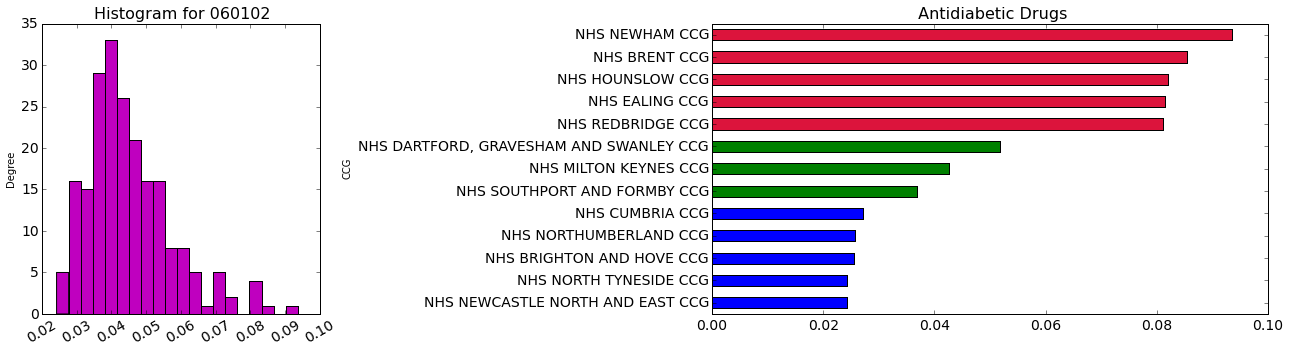

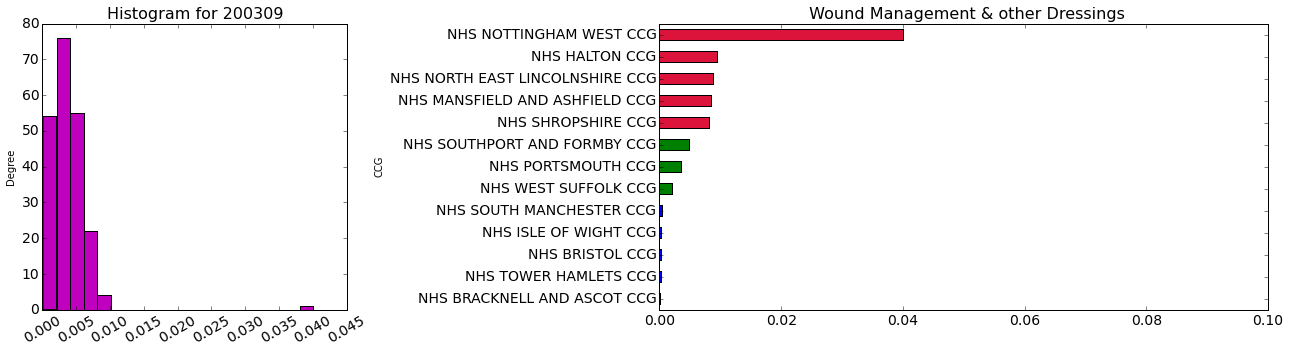

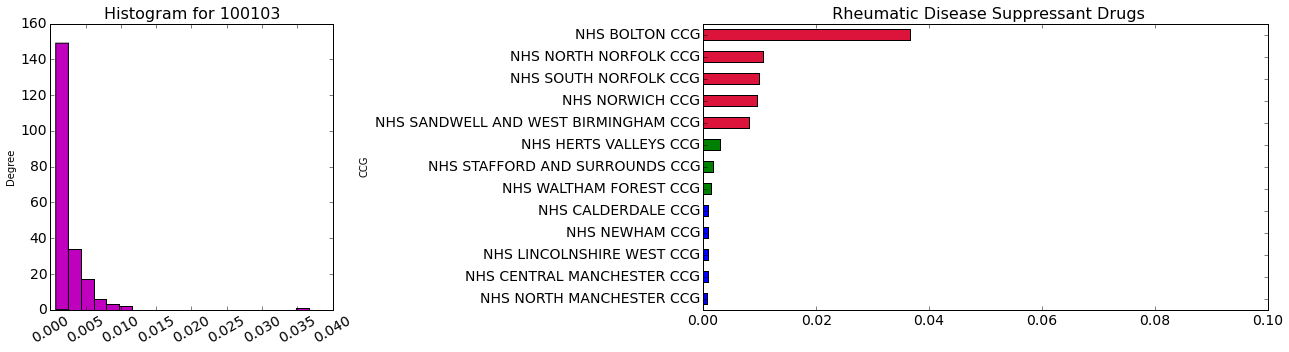

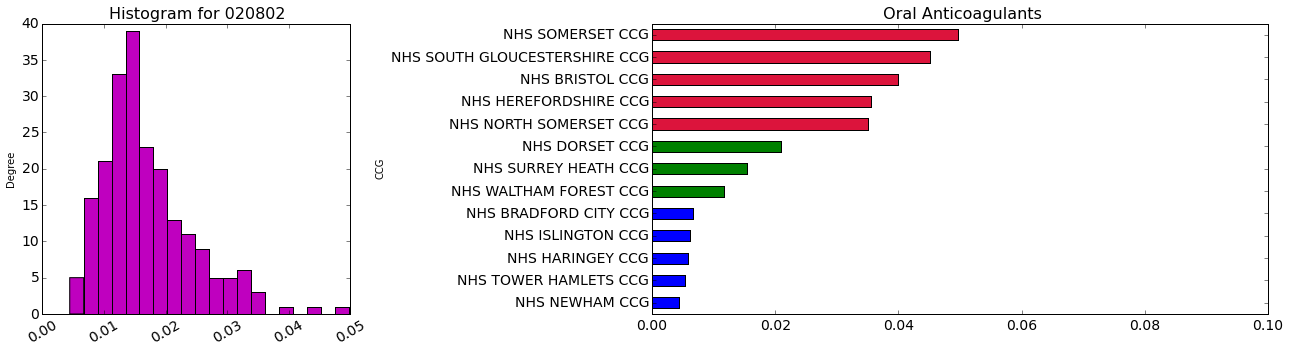

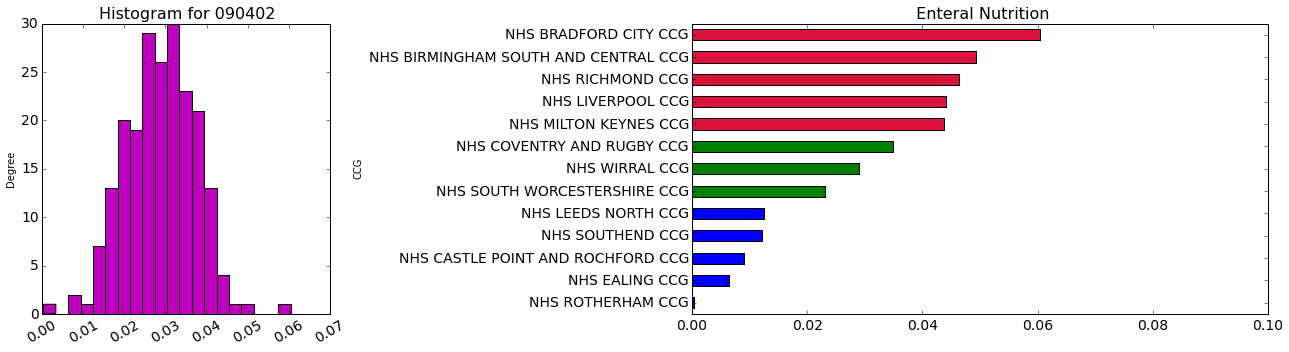

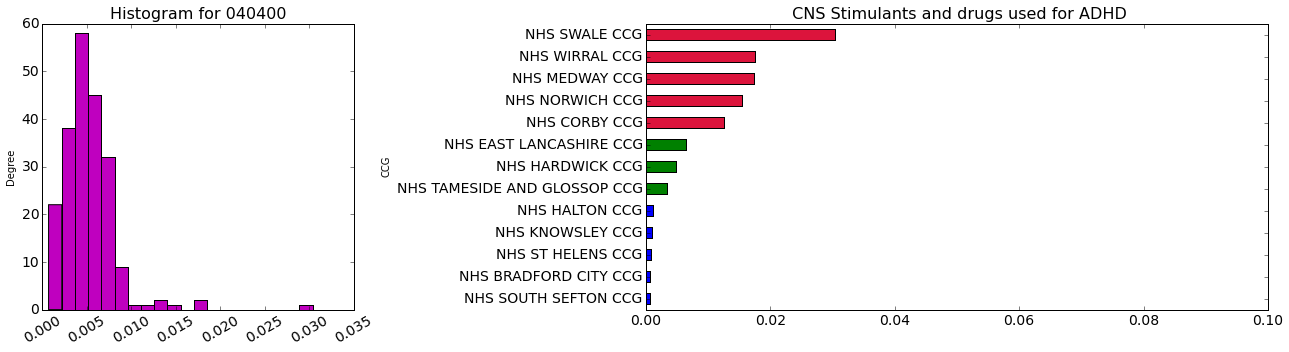

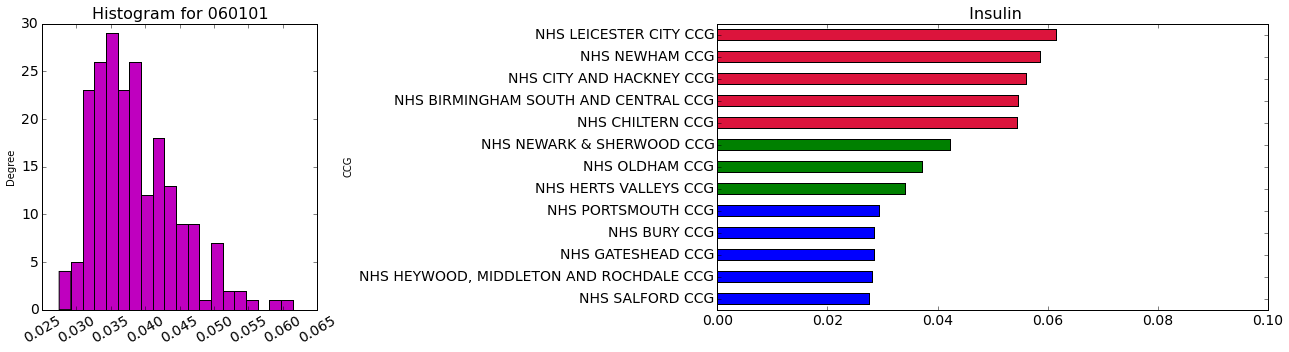

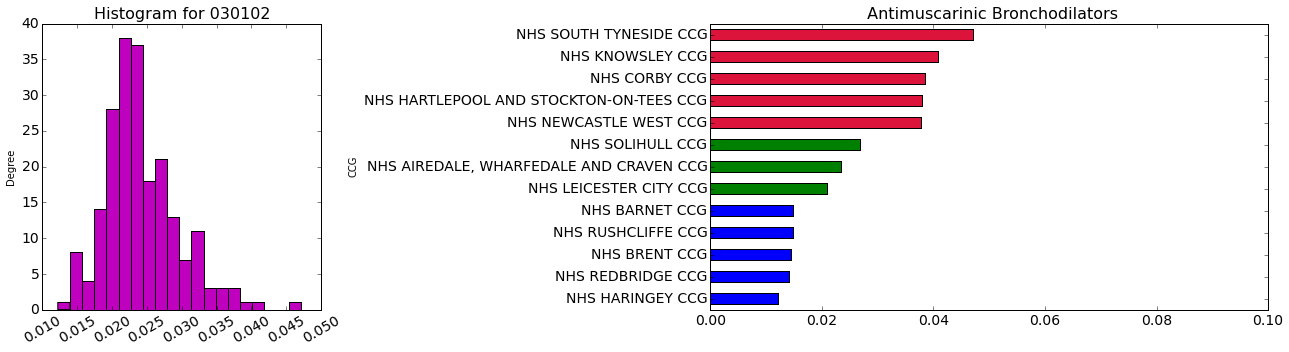

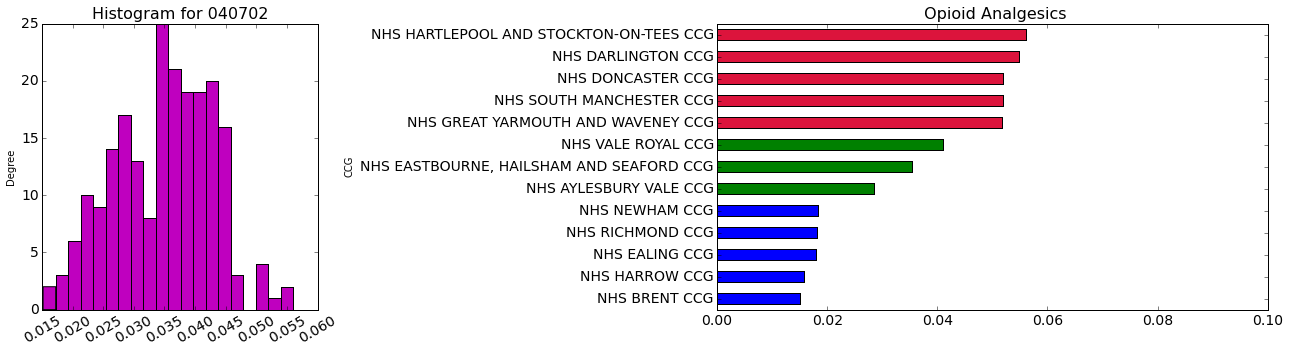

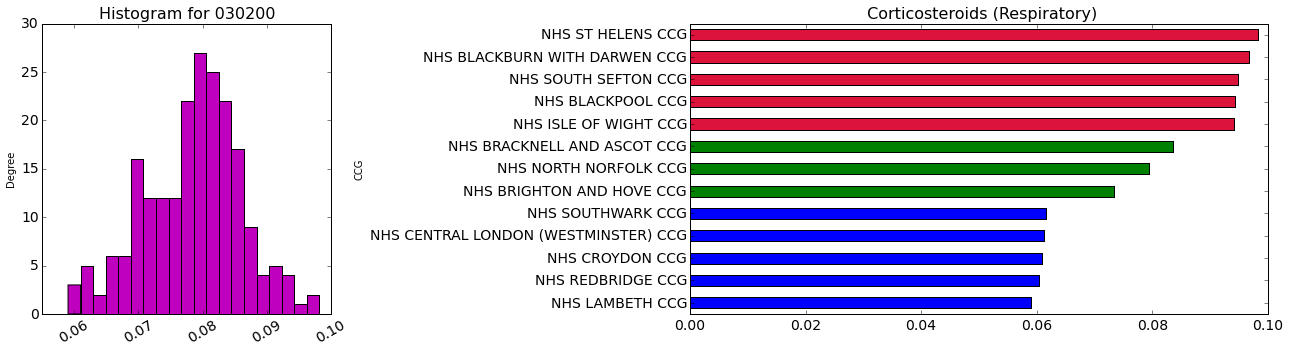

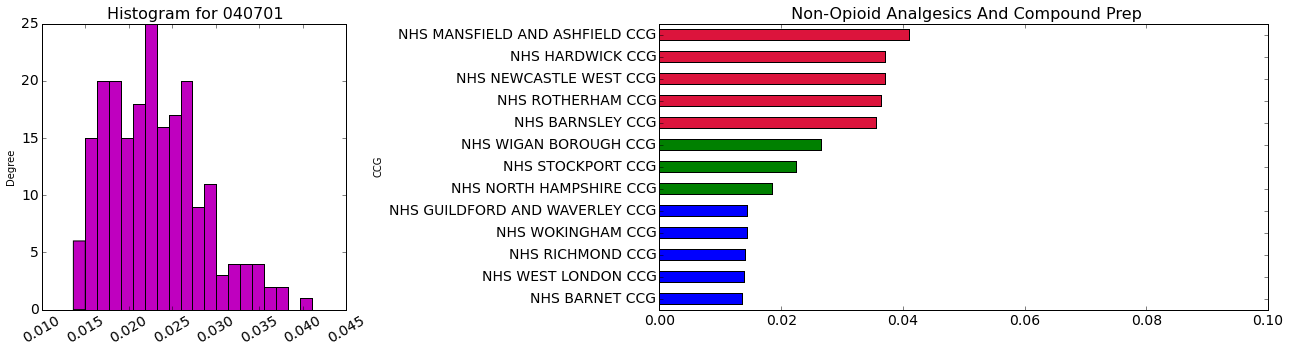

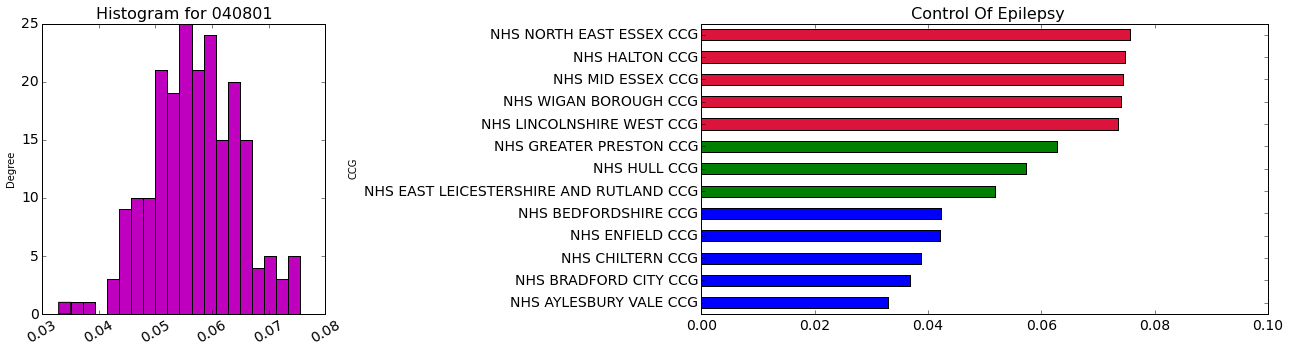

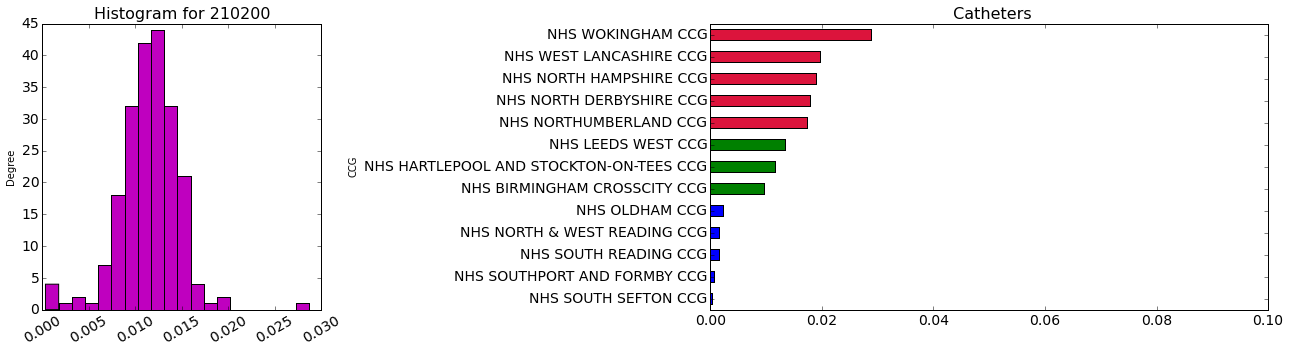

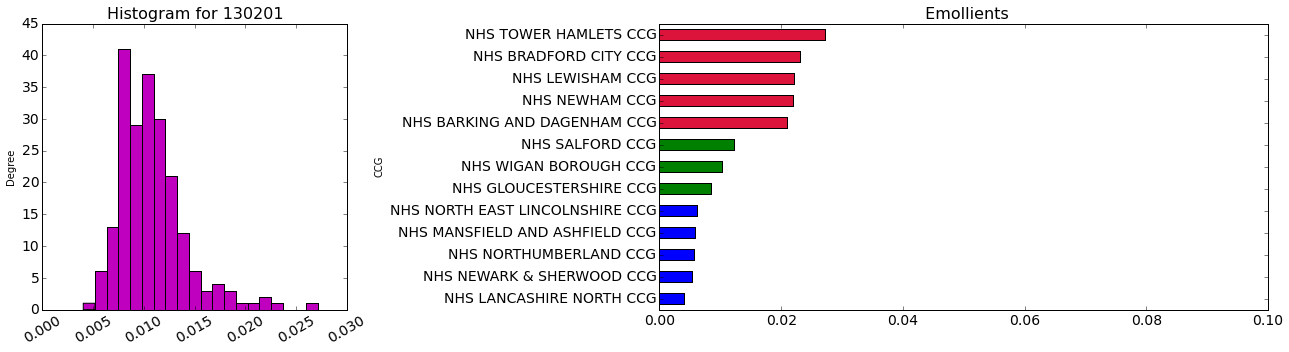

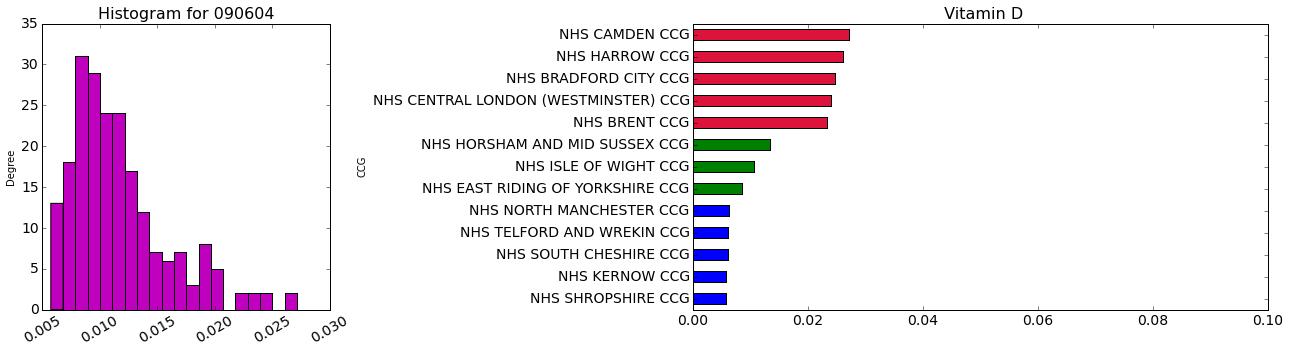

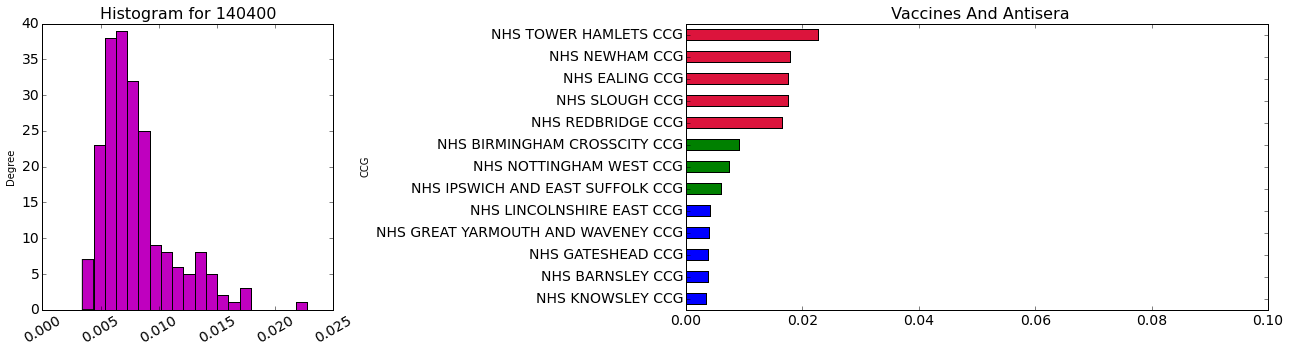

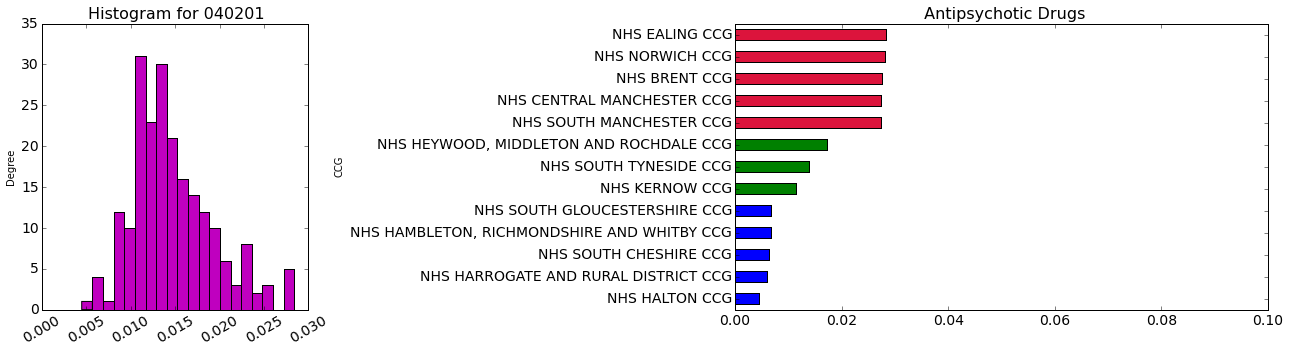

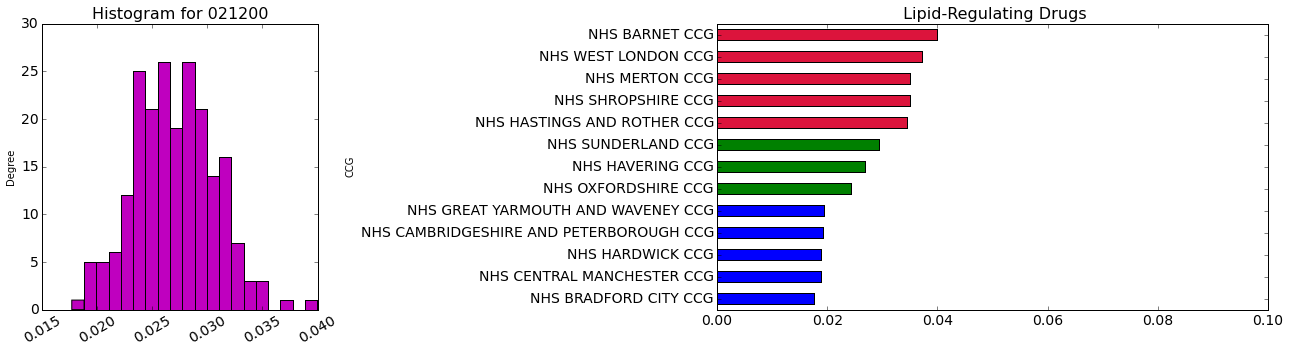

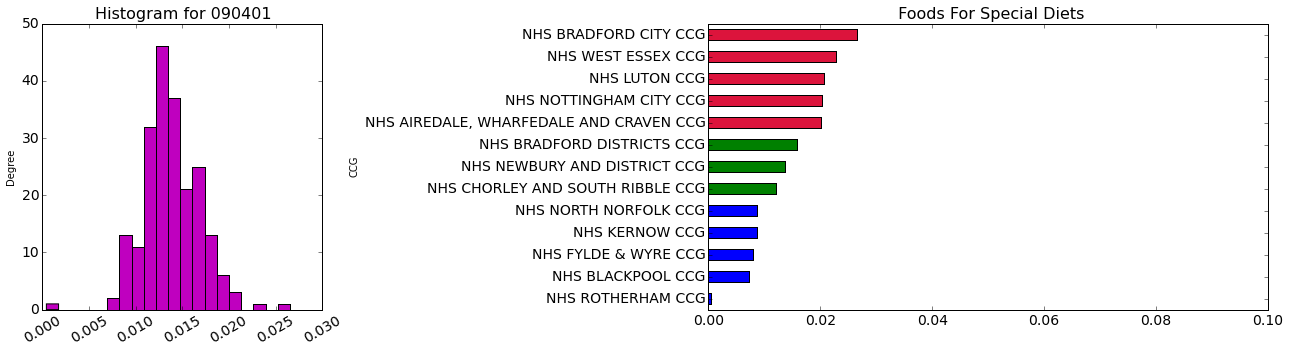

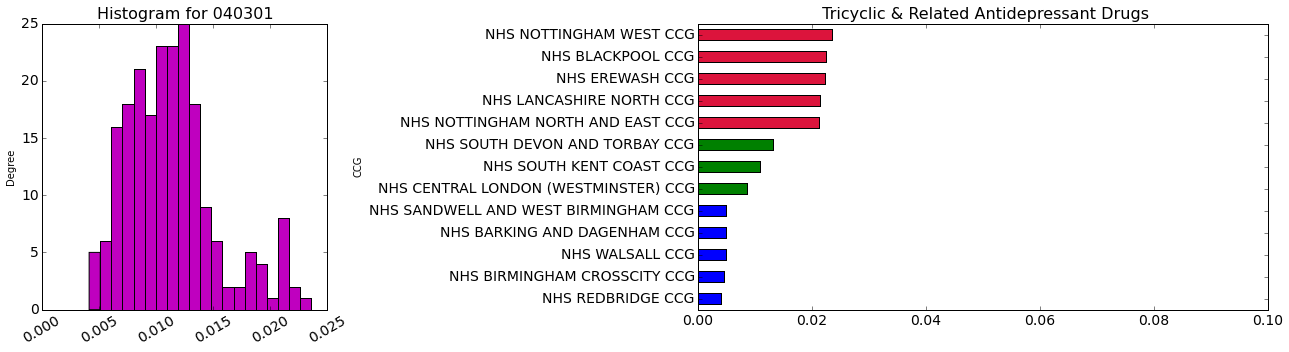

In [101]:
def score(x):
    return np.max(x)-np.median(x)
scores=para_ccg2[['FRAC_ACT_COST']].groupby(level=0).agg(score).sort(columns=['FRAC_ACT_COST'],ascending=False)
for highscorer in scores[:20].index:
    plot_folded(highscorer,xlim=(0,0.1))